Сделайте оценку того, как блоки слов в словаре влияют на точность классификации (на любой базе, например, распознавание писателей). Для этого выполните следующее:

Сформируйте словарь.
Используйте первые 50000 слов из словаря, который формируется токенайзером (50000 самых часто-используемых слов). Обучите нейросеть на этой базе.
Разбейте все слова на блоки по 100 слов последовательно.
Проверьте точность модели с помощью model.evaluate() на немного измененной проверочной выборке. Используя цикл, поочередно отключайте блоки по одному. Сделайте так, чтобы эти слова не использовались при предсказании, например, их индексы всегда приравнивались к 0.
Оцените, как меняется точность классификации на проверочной выборке.
Сделайте выводы, какие блоки слов влияют в плюс, а какие в минус.
Соберите итоговую подборку слов, в которую войдут только те блоки по 100 слов, которые улучшили точность (исключение которых давало падение точности).
Обучите сеть только на этих блоках слов.
Оцените изменение точности в сравнении с обучением на полном словаре (первые 50000 слов).

# Импорт библиотек

In [ ]:
from google.colab import files, drive
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
%matplotlib inline
 
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, SpatialDropout1D
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop
 
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
 
from sklearn.model_selection import train_test_split
 
import seaborn as sns
sns.set_style('darkgrid')

# Подключение к Гугл диску

In [ ]:
now = time.time()

drive.mount('/content/drive')
!rm '/content/illness'
!unzip -q '/content/drive/MyDrive/Lessons/lesson5/drive-download-20210817T100428Z-001.zip' -d '/content/illness'

print(f"Время обработки: {round(time.time() - 2, 2)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
rm: cannot remove '/content/illness': No such file or directory
Время обработки: 1633360305.68


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Вспомогательные функции

In [ ]:
def readText(fileName):
  file = open(fileName, 'r')
  text = file.read()
  text = text.split('\n')
  text_one, text_two = train_test_split(text, test_size=0.6, shuffle=True)
  
  return [" ".join(text_one), " ".join(text_two)]

In [ ]:
def getSet(wordIndex, xLen, step):
  sample = []
  wordLen = len(wordIndex)
  index = 0

  while (index + xLen <= wordLen):
    sample.append(wordIndex[index:index + xLen])
    index += step
  
  return sample

In [ ]:
def getBigSet(wordIndexes, xLen, step):

  nClasses = len(wordIndexes)
  classesXSamples = []
  for wI in wordIndexes:
    classesXSamples.append(getSet(wI, xLen, step))

  xSamples = []
  ySamples = []

  
  for ii in range(nClasses):

    yy = utils.to_categorical(ii, nClasses)
    for elem in classesXSamples[ii]:

      ySamples.append(yy)
      xSamples.append(elem)


  return (np.array(xSamples), np.array(ySamples))

In [ ]:
xLen, step = 50, 5

In [ ]:
def multiTest(model, xTest, yTest, name, className):
  print("НЕЙРОНКА: ", name)
  print('-'*20)
  
  totalSumRec = 0

  nClasses = len(className)

  currPred = model.predict(xTest)
  currOut = np.argmax(currPred, axis=1)

  trueOut = np.argmax(yTest, axis=1)

  val = 0

  for ii in range(len(currOut)):
    if currOut[ii] == trueOut[ii]:
      val += 1

  return val/len(yTest)

In [ ]:
def showPicture(history, loss=True, accuracy=True):
  
  if loss:
    plt.figure(figsize = (14, 7))
    plt.plot(history.history['loss'], 
            label='Значение ошибки на обучающем наборе')
    plt.plot(history.history['val_loss'], 
            label='Значение ошибки на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Значение ошибки')
    plt.legend()
    plt.show()
  
  if accuracy:
    plt.figure(figsize = (14, 7))
    plt.plot(history.history['accuracy'], 
            label='Доля верных ответов на обучающем наборе')
    plt.plot(history.history['val_accuracy'], 
            label='Доля верных ответов на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Доля верных ответов')
    plt.legend()
    plt.show()

In [ ]:
def create_model(xLen=50):
  model = Sequential()
  model.add(Dense(100, activation="relu", input_shape=(xLen,)))
  model.add(Dense(100, activation="relu"))
  model.add(Dense(10, activation="softmax"))

  model.compile(optimizer=Adam(lr=0.0001),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

  model.summary()

  return model

# Функция создания модели

In [ ]:
def createModel(maxWordsCount=20000, xLen=100, level=1):
  model = Sequential()

  model.add(Embedding(maxWordsCount, 5, input_length=xLen))
  model.add(SpatialDropout1D(0.2))
  model.add(BatchNormalization())

  if level not in [1, 2, 3, 4]:
    level = 1

  if level == 1:
    model.add(SimpleRNN(4))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))

  if level == 2:
    model.add(LSTM(4))

  if level == 3: 
    model.add(Conv1D(20, 5, activation='relu', padding='same'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Flatten())

  if level == 4:
    model.add(LSTM(4, return_sequences=1))
    model.add(Dense(100, activation='relu'))
    model.add(Conv1D(20, 5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Flatten())


  model.add(Dense(10, activation="softmax"))

  model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  
  model.summary()

  return model

# Подготовка данных

In [ ]:
classes = list()
for name in os.listdir("illness/"):
  classes.append(name.split('.')[0])

In [ ]:
xTrain, yTotal = [], []
xTest = list()

for name in os.listdir("illness/"):
  yTotal.append(name.split('.')[0])
  text = readText(f"illness/{name}")
  xTrain.append(text[0])
  xTest.append(text[1])


In [ ]:
print(xTrain[4])

отрыжка,  Отрыжка, боль под ложечкой различной интенсивности,в разное время суток,в том числе "голодные", ночные, могут быть постоянными в виде распирания и тяжести,   отрыжка, голодные боли, Желтизна кожных покровов и белов глаз болезненность при пальпации в эпигастральной области. вздутие живота тяжесть в эпигастрии после еды,   боли после сна. тошнота,  рвота слабость, боли в эпигастральной области (голодные, ночные, через 15-20 минут или 1-1,5 часа после еды); запоры. Неприятный привкус во рту; напряжение передней брюшной стенки. ощущение тяжести, отрыжка, продолжительная икота (около получаса); Учащенное сердцебиение, газообразование,  боли в подложечной области, распирания в подложечной области,  головная боль, рвота,  - язык обложен белым налетом рвота,  Отсутствие аппетита; тошнота (возникает сразу после еды); рвота и изжога. рвота с примесью желчи; тошнота, повышение температуры, головокружение;  появление неустойчивого стула,склонного к послаблению,  боли в области желудка,  

In [ ]:
print(type(xTrain))

<class 'list'>


Константы

In [ ]:
xLen, step = 100, 10
maxWordsCount = 50000
epochs = 50

In [ ]:
tokenizer = Tokenizer(num_words=maxWordsCount,
                      filters='–—!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\xa0–\ufeff',
                      lower=True,
                      char_level=False,
                      oov_token="noName",
                      split=' ')

tokenizer.fit_on_texts(xTrain)
train_index = tokenizer.texts_to_sequences(xTrain)
test_index = tokenizer.texts_to_sequences(xTest)

xTrain, yTrain = getBigSet(train_index, xLen, step)
xTest, yTest = getBigSet(test_index, xLen, step)

In [ ]:
print(len(xTrain))

242


# Создание и обучение модели

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 5)            100000    
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 100, 5)            0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 100, 5)            20        
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 4)                 40        
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               500       
_________________________________________________________________
dense_12 (Dense)             (None, 10)               

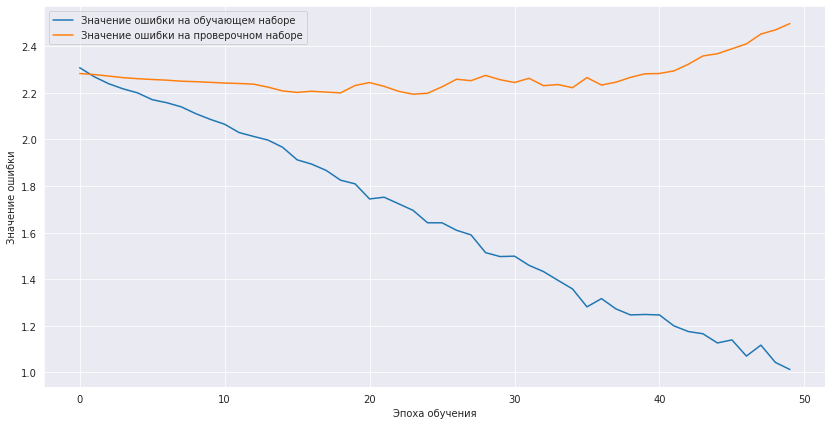

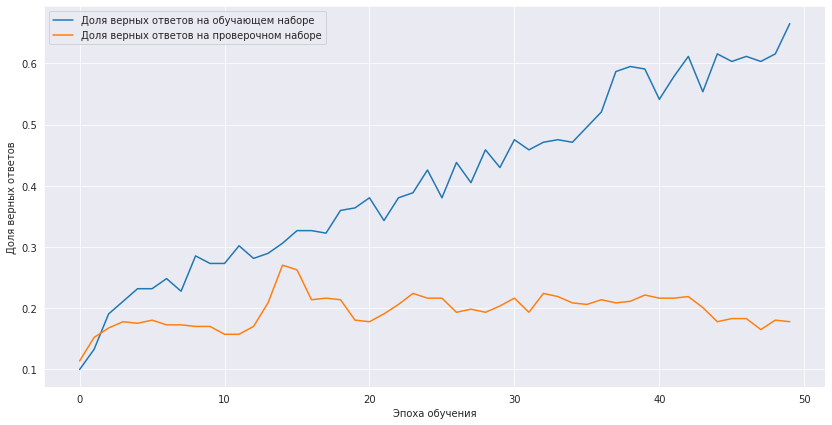

НЕЙРОНКА:  test
--------------------
Процент точности модели: 18.0%


In [ ]:
model = createModel(level=1)

print(plot_model(model, dpi=60, show_shapes=True))
history = model.fit(xTrain,
                    yTrain,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(xTest, yTest),
                    verbose=1)

showPicture(history)

currOut = multiTest(model, xTest, yTest, "test", yTotal)
print(f"Процент точности модели: {round(currOut, 2)*100}%")

# Отбор наиболее влиятельных примеров

In [ ]:
result = model.evaluate(xTest, yTest)[1]
mainTest = list()

for ii in range(len(xTest)):
  x = xTest.copy()
  y = yTest.copy()

  x[ii] = [0 for i in range(100)]
  y[ii] = utils.to_categorical(0, 10)

  res = model.evaluate(x, y)[1]
  if res < result:
    mainTest.append((xTest[ii], yTest[ii]))


In [ ]:
x, y = list(), list()
for elem in mainTest:
  a, b = elem
  x.append(a)
  y.append(b)
x = np.array(x)
y = np.array(y)

In [ ]:
print(len(x))
print(len(y))

80
80


# Модель, работающая только на отобранной выборке

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 5)            100000    
_________________________________________________________________
spatial_dropout1d_12 (Spatia (None, 100, 5)            0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 100, 5)            20        
_________________________________________________________________
lstm_9 (LSTM)                (None, 4)                 160       
_________________________________________________________________
dense_15 (Dense)             (None, 10)                50        
Total params: 100,230
Trainable params: 100,220
Non-trainable params: 10
_________________________________________________________________
<IPython.core.display.Image object>
Epoch 1/50
9/9 [==============================] - 3s 124ms/step - loss: 2.27

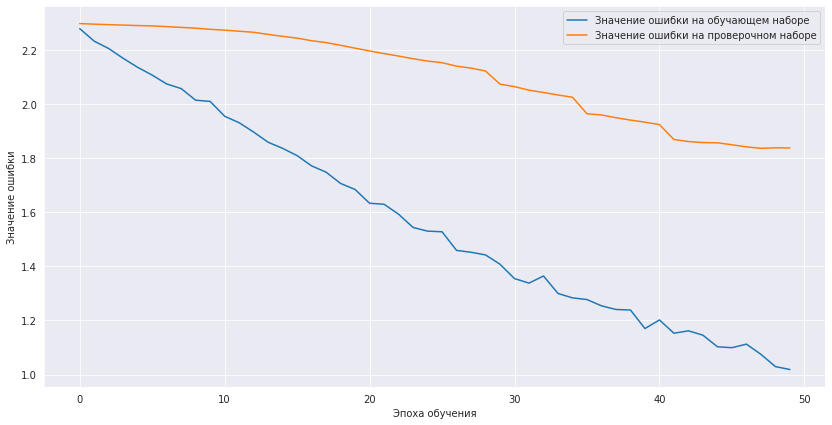

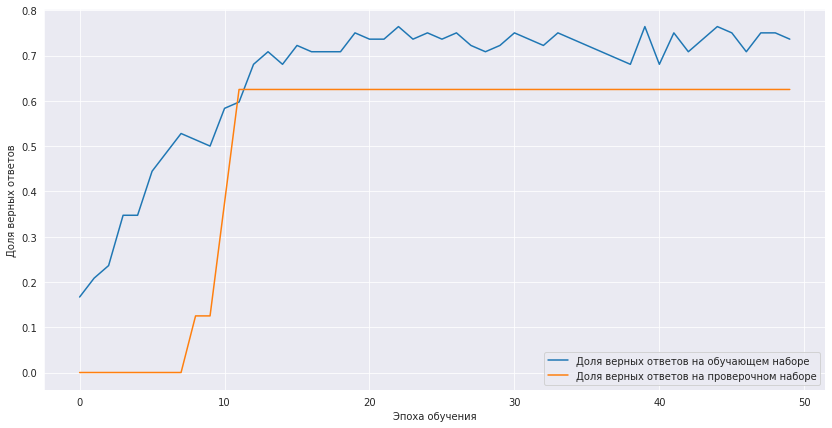

НЕЙРОНКА:  test
--------------------
Процент точности модели: 34.0%


In [ ]:
model = createModel(level=2)

print(plot_model(model, dpi=60, show_shapes=True))
history = model.fit(x,
                    y,
                    epochs=epochs,
                    batch_size=8,
                    validation_split=0.1,
                    verbose=1)

showPicture(history)

currOut = multiTest(model, xTest, yTest, "test", yTotal)
print(f"Процент точности модели: {round(currOut, 2)*100}%")

Вывод. На данной подборке модель стала точнее